# CHECK GPU

In [13]:
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

Num GPUs Available:  1
['/device:CPU:0', '/device:GPU:0']


# REMOVE DODGY IMAGES

<div class="alert alert-block alert-info">
<b>Tip:</b> you can skip this part unless you add new data
</div>



In [14]:
import os
import cv2
import imghdr

data_dir = os.path.join('data','raw_data')


image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
            else:
                # Convert the image to RGBA if it has a palette
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# CHECK DATA

In [41]:
import os
import shutil
import random

data_dir = "data/raw_data/"
# Define source and destination directories
source_dirs = os.listdir(data_dir)
print('classes:', source_dirs)

# Check if the destination directories already exist
train_dest = os.path.join('data', 'train')
valid_dest = os.path.join('data', 'valid')

classes: ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic']


<div class="alert alert-block alert-info">
<b>Tip:</b> you can skip this part below also if there is already training and validation directory unless you want to delete and create a new ones
</div>

split the data from data/raw_data to training and validation data

In [42]:
#create training and validation data
train_dir_exists = os.path.exists(train_dest)
valid_dir_exists = os.path.exists(valid_dest)

if train_dir_exists or valid_dir_exists:
    # Ask the user for their choice
    choice = input("Destination directories already exist. Do you want to:\n"
                   "1. Skip the process (S)\n"
                   "2. Delete existing directories and create new ones (D)\n"
                   "Enter 'S' or 'D': ").strip().lower()

    if choice != 's' and choice != 'd':
        print("Invalid choice. Exiting.")
        exit()

    if choice == 's':
        print("Skipping the process.")
        exit()
    elif choice == 'd':
        print("Deleting existing directories and creating new ones.")

        if train_dir_exists:
            shutil.rmtree(train_dest)
        if valid_dir_exists:
            shutil.rmtree(valid_dest)

# Set the training-validation split ratio
split_ratio = 0.8

# Create destination directories
os.makedirs(train_dest, exist_ok=True)
os.makedirs(valid_dest, exist_ok=True)

# Initialize lists to track images in training and validation sets
training_images = []
validation_images = []

# Loop through source directories
for source_dir in source_dirs:
    source_dir_path = os.path.join(data_dir, source_dir)
    train_class_dest = os.path.join(train_dest, source_dir)
    valid_class_dest = os.path.join(valid_dest, source_dir)

    os.makedirs(train_class_dest, exist_ok=True)
    os.makedirs(valid_class_dest, exist_ok=True)

    files = os.listdir(source_dir_path)
    
    if len(set(files)) != len(files):
        print(f"Warning: Duplicate filenames found in {source_dir}. Please ensure all filenames are unique.")
    
    random.shuffle(files)  # Shuffle the list once

    split_point = int(len(files) * split_ratio)

    # Copy files to training and validation destinations and track them
    for file in files[:split_point]:
        image_path = os.path.join(train_class_dest, file)
        training_images.append(image_path)
        shutil.copy(os.path.join(source_dir_path, file), image_path)
    for file in files[split_point:]:
        image_path = os.path.join(valid_class_dest, file)
        validation_images.append(image_path)
        shutil.copy(os.path.join(source_dir_path, file), image_path)

# Check for duplicates between training and validation sets
duplicates = set(training_images) & set(validation_images)

if duplicates:
    print(f"Warning: Duplicates found between training and validation sets: {duplicates}")
else:
    print("No duplicates found between training and validation sets.")


Deleting existing directories and creating new ones.
No duplicates found between training and validation sets.


# INSPECT THE IMAGE

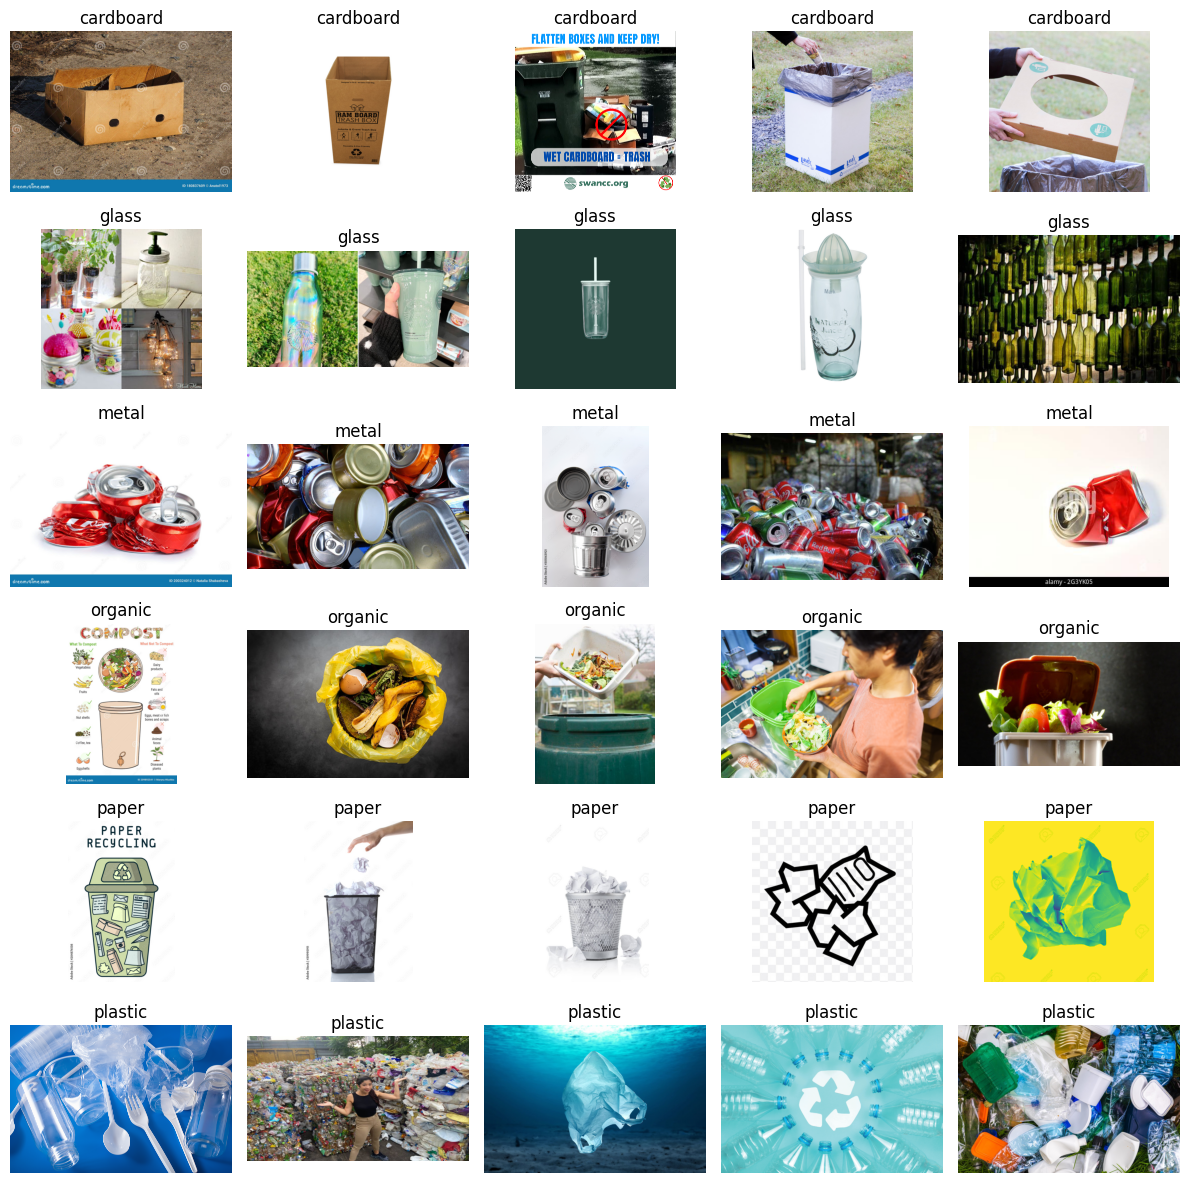

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the directory for inspection (e.g., train or valid)
inspection_dir = train_dest  # You can change this to valid_dest if needed

# List the class directories within the inspection directory
class_dirs = os.listdir(inspection_dir)

# Number of rows and columns for each class collage
num_rows = len(class_dirs)  # One row per class
num_cols = 5

# Create a new figure
fig = plt.figure(figsize=(12, 12))

# Loop through each class to display a 5x5 collage
for class_index, class_dir in enumerate(class_dirs):
    class_path = os.path.join(inspection_dir, class_dir)
    class_files = os.listdir(class_path)

    num_images_to_inspect = min(num_cols, len(class_files))

    for i in range(num_images_to_inspect):
        img_path = os.path.join(class_path, class_files[i])
        img = mpimg.imread(img_path)

        # Add a subplot to the figure
        ax = fig.add_subplot(num_rows, num_cols, class_index * num_cols + i + 1)
        ax.imshow(img)
        ax.set_title(class_dir)
        ax.axis('off')

# Adjust layout and display the collage
plt.tight_layout()
plt.show()


# PREPROCESS


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

training_datagen = ImageDataGenerator(
    rescale=1./255.,
	rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    train_dest,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	valid_dest,
	target_size=(224,224),
	class_mode='categorical',
    batch_size=126
)


Found 19582 images belonging to 6 classes.
Found 4899 images belonging to 6 classes.


# MODELING

In [73]:
import tensorflow_hub as hub

mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

feature_extractor_model = mobilenet_v3

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6,activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1001)              5508713   
                                                                 
 dense_7 (Dense)             (None, 512)               513024    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 6,024,815
Trainable params: 516,102
Non-trainable params: 5,508,713
_________________________________________________________________


In [74]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['acc'])

# CALLBACK

In [75]:
%load_ext tensorboard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=3)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<div class="alert alert-block alert-warning">
<b>Warning:</b> Don't run cell below if you want to save the previous logs
</div>

In [76]:
import shutil

# Clear any logs from previous runs
shutil.rmtree('./logs/')

# TRAINING


In [77]:
NUM_EPOCHS = 10

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=[tensorboard_callback,early_stopping])

Epoch 1/10


c:\Users\abeyn\miniconda3\envs\tf\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


156/156 [==============================] - 273s 2s/step - loss: 0.4145 - acc: 0.8670 - val_loss: 0.2992 - val_acc: 0.9014
Epoch 2/10
156/156 [==============================] - 259s 2s/step - loss: 0.2452 - acc: 0.9175 - val_loss: 0.2901 - val_acc: 0.9069
Epoch 3/10
156/156 [==============================] - 256s 2s/step - loss: 0.2006 - acc: 0.9315 - val_loss: 0.2813 - val_acc: 0.9149
Epoch 4/10
156/156 [==============================] - 263s 2s/step - loss: 0.1708 - acc: 0.9412 - val_loss: 0.2658 - val_acc: 0.9186
Epoch 5/10
156/156 [==============================] - 261s 2s/step - loss: 0.1428 - acc: 0.9505 - val_loss: 0.2551 - val_acc: 0.9239
Epoch 6/10
156/156 [==============================] - 260s 2s/step - loss: 0.1301 - acc: 0.9549 - val_loss: 0.2666 - val_acc: 0.9204
Epoch 7/10
156/156 [==============================] - 265s 2s/step - loss: 0.1167 - acc: 0.9605 - val_loss: 0.2976 - val_acc: 0.9161
Epoch 8/10
156/156 [==============================] - 258s 2s/step - loss: 0.108

# ACCURACY

In [78]:
#tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 13544), started 1 day, 0:04:52 ago. (Use '!kill 13544' to kill it.)

acc : [0.866969645023346, 0.9174752235412598, 0.9314676523208618, 0.9411704540252686, 0.9505158066749573, 0.9549075961112976, 0.9605249762535095, 0.9620569944381714, 0.9628229737281799, 0.9648656845092773]
val_acc : [0.9014084339141846, 0.9069197773933411, 0.9148805737495422, 0.9185547828674316, 0.9238620400428772, 0.9203919172286987, 0.916105329990387, 0.9183506965637207, 0.9256991147994995, 0.9224331378936768]
loss : [0.41452211141586304, 0.24517107009887695, 0.20057277381420135, 0.1707857847213745, 0.14282475411891937, 0.13009941577911377, 0.11669684946537018, 0.10871684551239014, 0.10335516184568405, 0.09835635125637054]
val_loss : [0.29924362897872925, 0.2901347279548645, 0.28129181265830994, 0.26581838726997375, 0.2550520896911621, 0.26657554507255554, 0.29760706424713135, 0.3028402626514435, 0.2838214039802551, 0.3007051646709442]


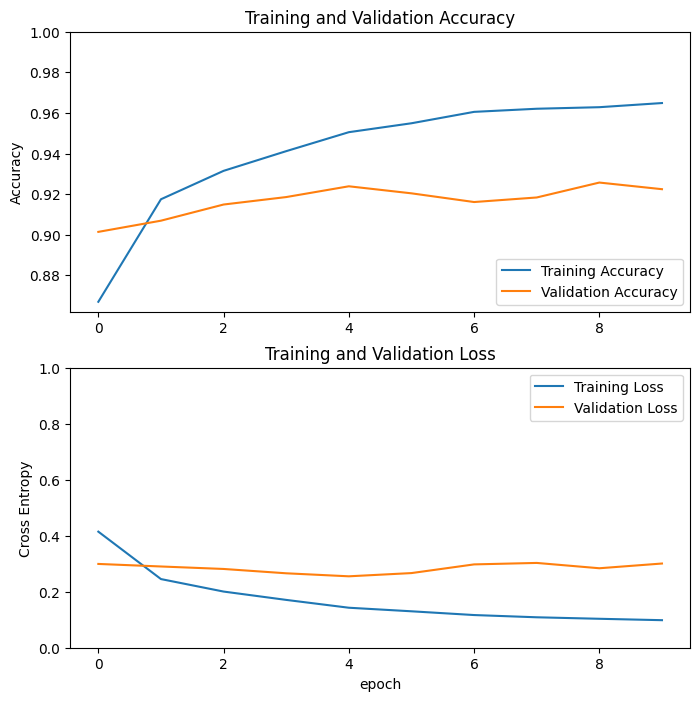

In [79]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy values from the 'history' object
acc = history.history['acc']
val_acc = history.history['val_acc']

print('acc :',acc)
print('val_acc :',val_acc)

# Extract training and validation loss values from the 'history' object
loss = history.history['loss']
val_loss = history.history['val_loss']

print('loss :',loss)
print('val_loss :',val_loss)

# Create a new figure with two subplots
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)  # First subplot (top)
plt.plot(acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add a legend in the lower right corner
plt.ylabel('Accuracy')  # Label for the y-axis
plt.ylim([min(plt.ylim()), 1])  # Set y-axis limits
plt.title('Training and Validation Accuracy')  # Title for the subplot

plt.subplot(2, 1, 2)  # Second subplot (bottom)
plt.plot(loss, label='Training Loss')  # Plot training loss
plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add a legend in the upper right corner
plt.ylabel('Cross Entropy')  # Label for the y-axis
plt.ylim([0, 1.0])  # Set y-axis limits
plt.title('Training and Validation Loss')  # Title for the subplot
plt.xlabel('epoch')  # Label for the x-axis
plt.show()  # Display the plot


# TEST

1/1 [==============================] - 0s 26ms/step
Predicted class for data\test\03154fd3-00a8-47d1-b1ac-0cb7d3a0696f.jpg is Plastic
Class index: 5


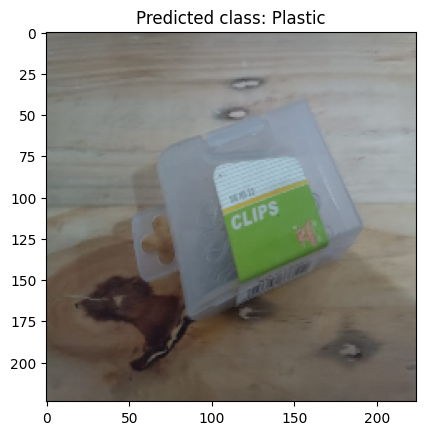

1/1 [==============================] - 0s 24ms/step
Predicted class for data\test\2034adf4-6acc-43b9-bd12-df5aacd1a0d3.jpg is Paper
Class index: 4


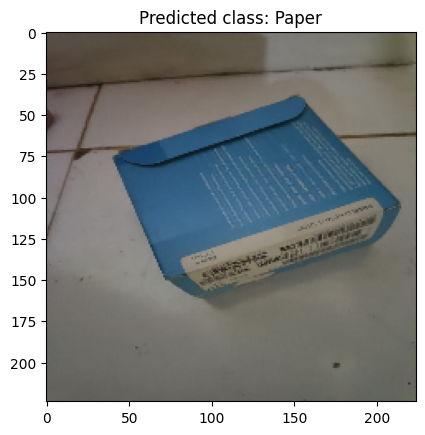

1/1 [==============================] - 0s 23ms/step
Predicted class for data\test\4d764bc8-3e8e-40ce-be28-88f700a32948.jpg is Cardboard
Class index: 0


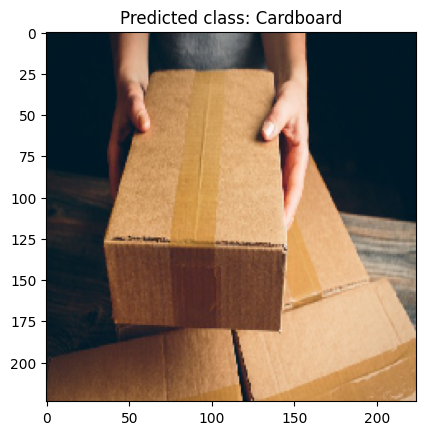

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\61a2b31c-af2e-490c-a8f8-49c61b5350ac.jpg is Glass
Class index: 1


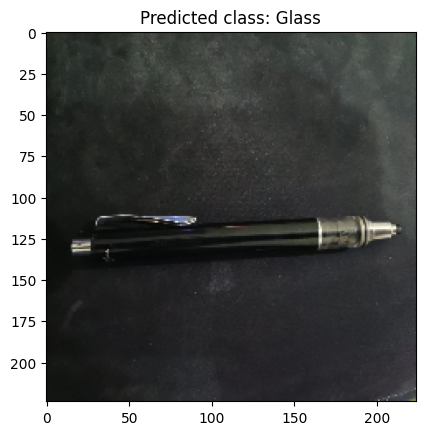

1/1 [==============================] - 0s 28ms/step
Predicted class for data\test\675ac41f-9b57-47e4-8599-a2fbdcb35c57.jpg is Paper
Class index: 4


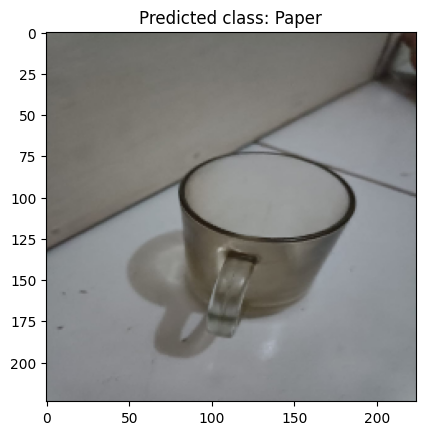

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\6f23a35c-db6a-4ed2-b000-5b7cb63d2a8e.jpg is Cardboard
Class index: 0


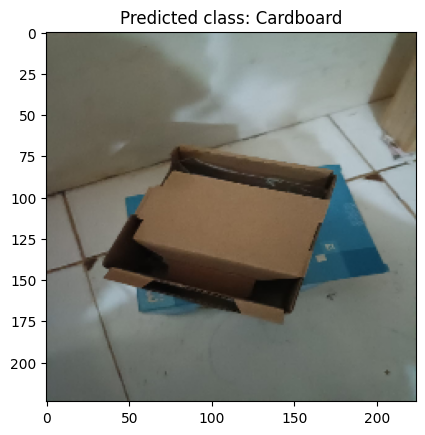

1/1 [==============================] - 0s 23ms/step
Predicted class for data\test\7a8c5202-e804-49b7-82b1-6099bdb796f7.jpg is Glass
Class index: 1


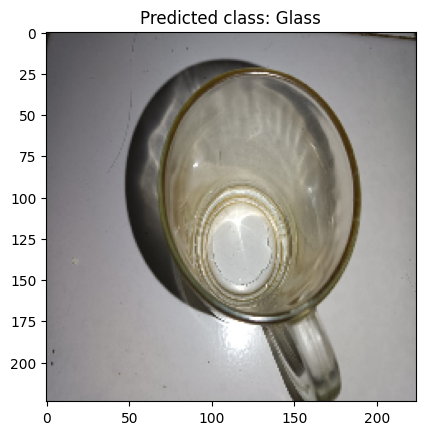

1/1 [==============================] - 0s 23ms/step
Predicted class for data\test\8adf1acb-5995-4a39-85e7-e37d01313d7a.jpg is Plastic
Class index: 5


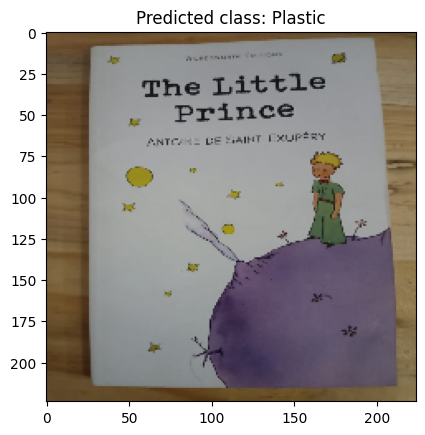

1/1 [==============================] - 0s 23ms/step
Predicted class for data\test\8ef774ff-b6da-4740-a0cd-d90a5d610990.jpg is Glass
Class index: 1


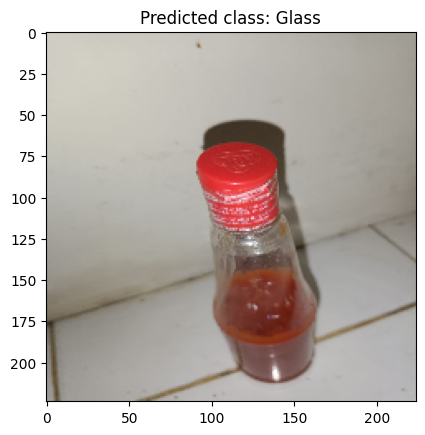

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\bottle.jpg is Metal
Class index: 2


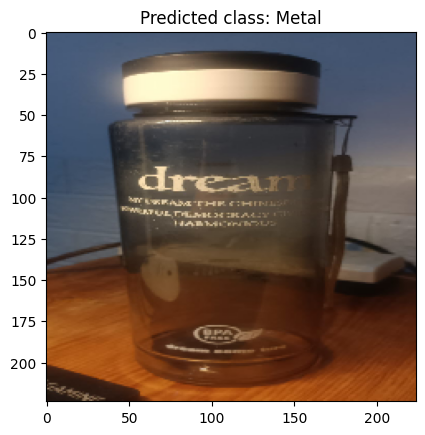

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\c865dc32-9802-4588-b5a3-055e286b73a5.jpg is Glass
Class index: 1


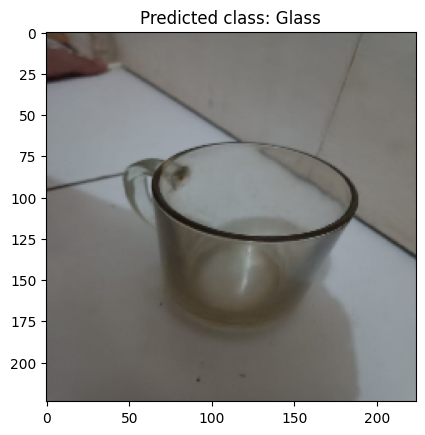

1/1 [==============================] - 0s 23ms/step
Predicted class for data\test\dd69b3f3-d4e8-4a5f-ba6b-8b237714dd03.jpg is Glass
Class index: 1


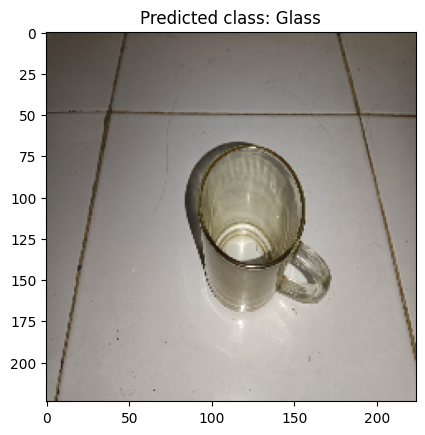

1/1 [==============================] - 0s 24ms/step
Predicted class for data\test\Drinkware.jpg is Glass
Class index: 1


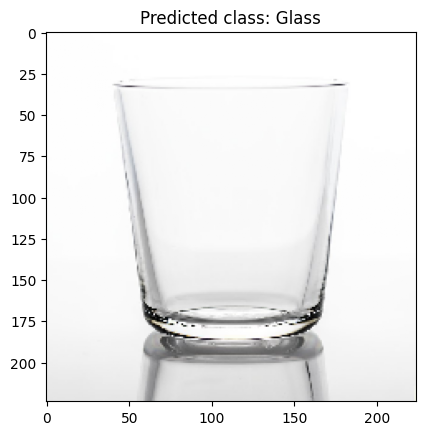

1/1 [==============================] - 0s 24ms/step
Predicted class for data\test\e9310565-c540-49fa-a606-c7d1fca33353.jpg is Paper
Class index: 4


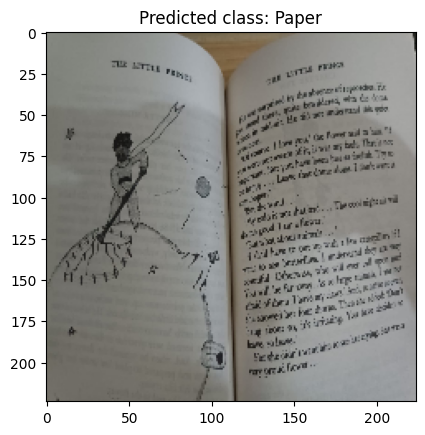

1/1 [==============================] - 0s 27ms/step
Predicted class for data\test\ec6f79ad-6499-44d5-a826-5beb73631993.jpg is Paper
Class index: 4


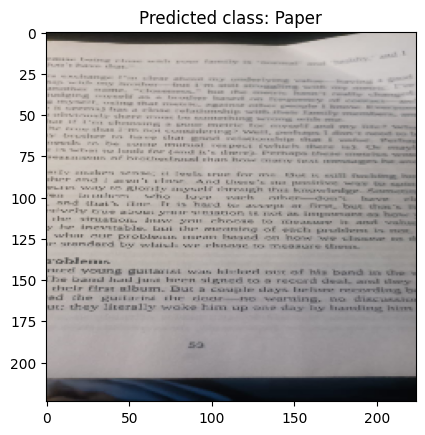

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\f26a1e41-e75d-4ac6-aa7b-985d2e90f7d0.jpg is Glass
Class index: 1


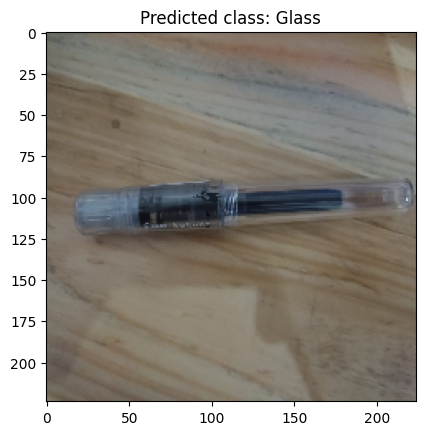

1/1 [==============================] - 0s 24ms/step
Predicted class for data\test\f94b4928-56a8-4475-80cd-2458942d0dbc.jpg is Glass
Class index: 1


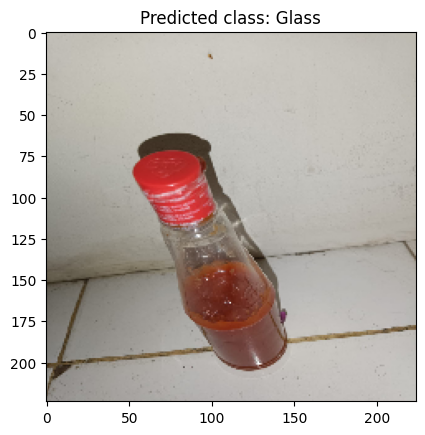

1/1 [==============================] - 0s 57ms/step
Predicted class for data\test\images.jpg is Metal
Class index: 2


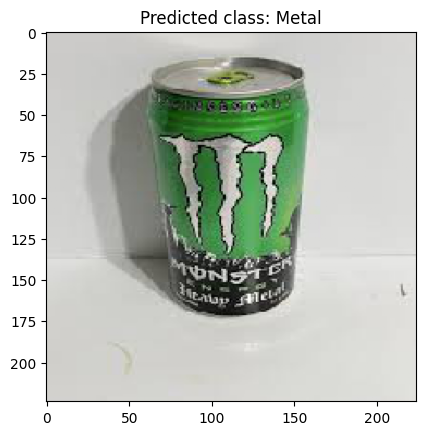

1/1 [==============================] - 0s 24ms/step
Predicted class for data\test\jonathan-cooper-0B3BaWvDtrI-unsplash-1.jpg is Plastic
Class index: 5


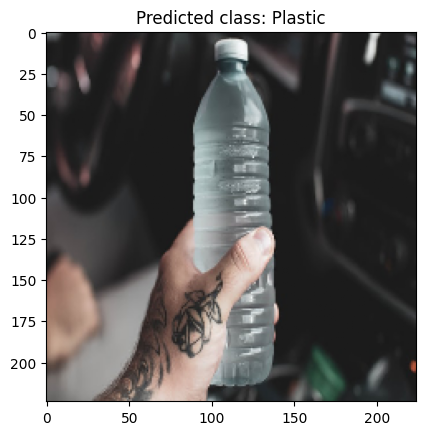

1/1 [==============================] - 0s 24ms/step
Predicted class for data\test\makanan.jpg is Organic
Class index: 3


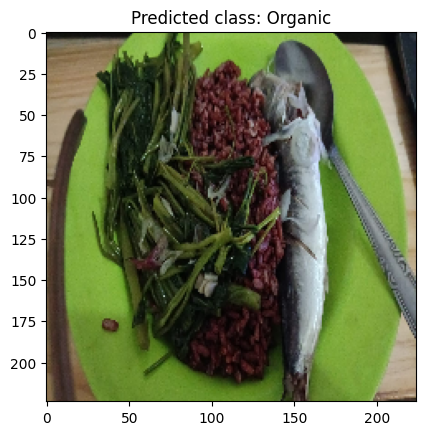

1/1 [==============================] - 0s 28ms/step
Predicted class for data\test\makanan2.jpg is Organic
Class index: 3


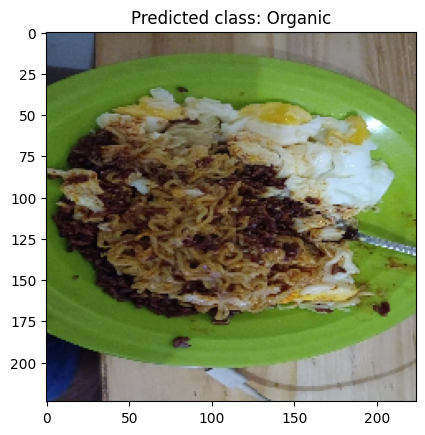

1/1 [==============================] - 0s 23ms/step
Predicted class for data\test\paper.jpg is Paper
Class index: 4


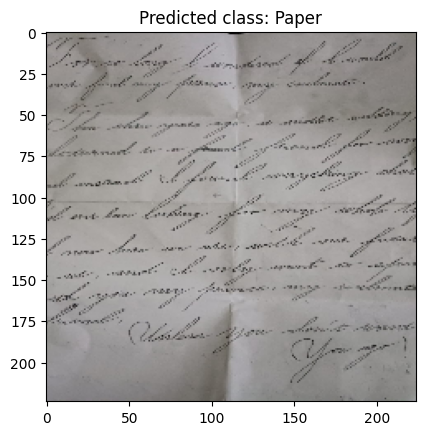

1/1 [==============================] - 0s 29ms/step
Predicted class for data\test\what to do with paper.jpeg is Paper
Class index: 4


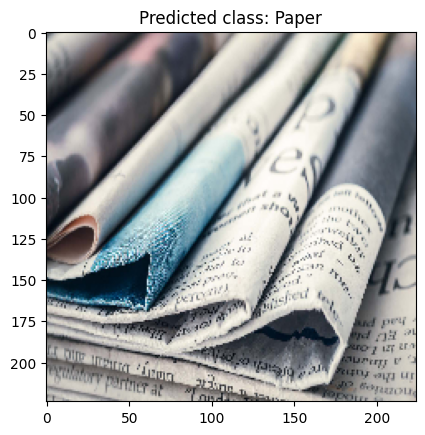

1/1 [==============================] - 0s 24ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 1.19.41 AM.jpeg is Cardboard
Class index: 0


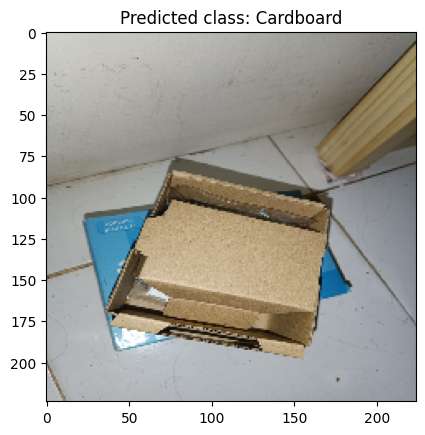

1/1 [==============================] - 0s 26ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 8.48.31 PM.jpeg is Paper
Class index: 4


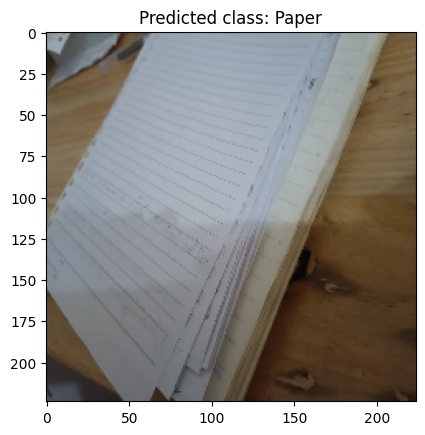

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 8.48.32 PM.jpeg is Paper
Class index: 4


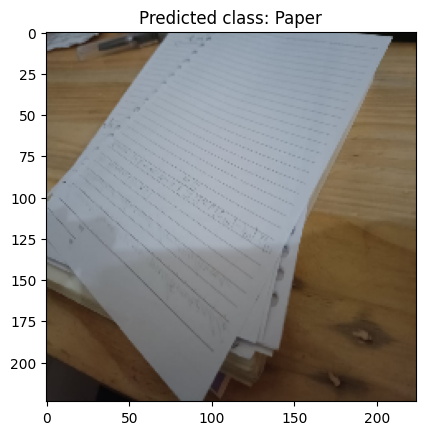

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 8.48.34 PM (1).jpeg is Metal
Class index: 2


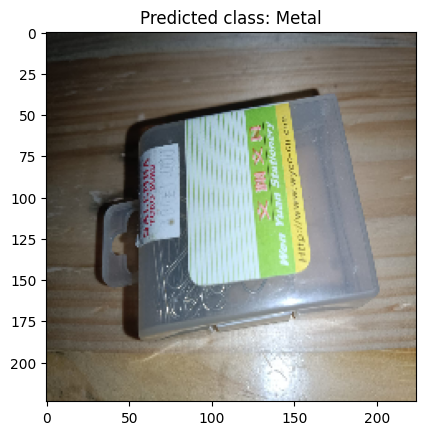

1/1 [==============================] - 0s 26ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 8.48.34 PM (2).jpeg is Plastic
Class index: 5


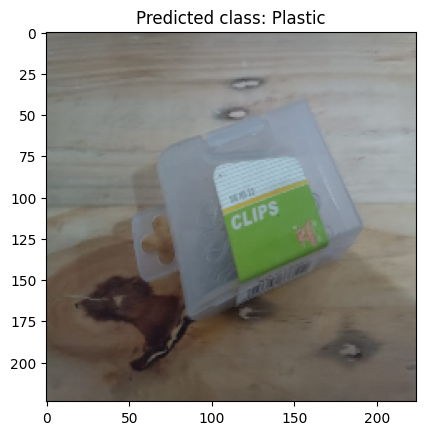

1/1 [==============================] - 0s 27ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 8.48.34 PM.jpeg is Metal
Class index: 2


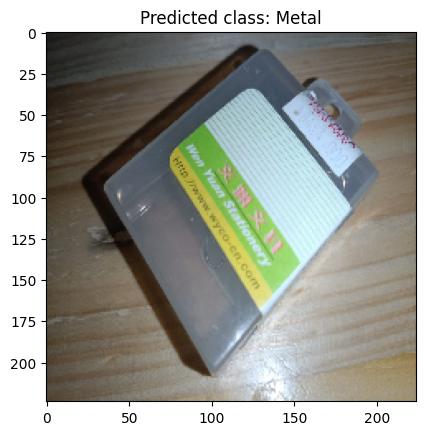

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 8.50.15 PM (1).jpeg is Organic
Class index: 3


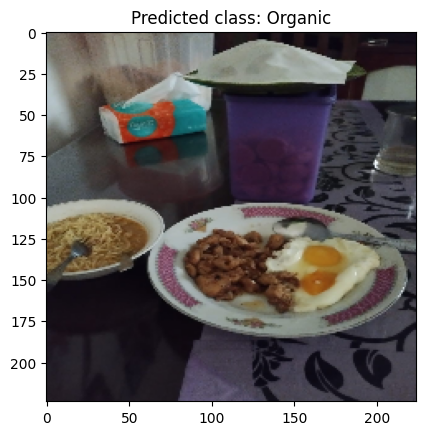

1/1 [==============================] - 0s 25ms/step
Predicted class for data\test\WhatsApp Image 2023-11-02 at 8.50.15 PM.jpeg is Organic
Class index: 3


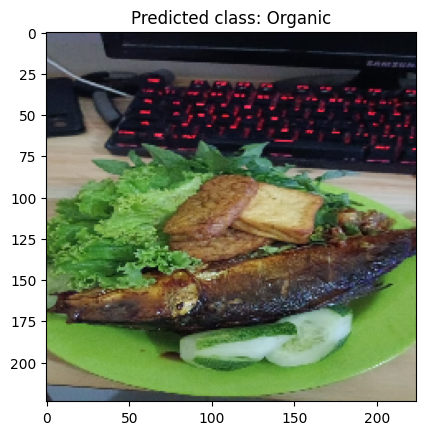

In [82]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

class_labels = ["Cardboard", "Glass", "Metal", "Organic", "Paper","Plastic"]

# Path to the directory containing your test images
test_dir = os.path.join('data','test')

# Get a list of all image files in the test directory
image_paths = [os.path.join(test_dir, file) for file in os.listdir(test_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]

for image_path in image_paths:
    # Load and preprocess the image using Pillow (PIL)
    img = load_img(image_path, target_size=(224, 224))  # Load and resize the image
    x = img_to_array(img)  # Convert the image to a NumPy array
    x = x / 255.0  # Normalize the pixel values to the range [0, 1]

    # Predict using the model
    yhat = model.predict(np.expand_dims(x, axis=0))
    predicted_class = np.argmax(yhat, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    print(f'Predicted class for {image_path} is {predicted_label}')
    print(f'Class index: {predicted_class}')

    plt.imshow(x)  # Display the resized image
    plt.title(f'Predicted class: {predicted_label}')
    plt.show()


# SAVE MODEL

In [84]:
# Save the model
model.save(os.path.join('models', 'multitrash.h5'))